In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import metrics
import tensorflow as tf
import tensorflow_hub as hub

Constantes a definir

In [2]:
RUTA_TRAIN = "../Datasets/tfg_dataset/train"
RUTA_TEST = "../Datasets/tfg_dataset/test"
RUTA_MODELOS = "../Modelos/"
RUTA_IMG = "../Memoria/img/"

DIM = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = .2
ENTRENAR = False

Funciones para visualizar un ejemplo del dataset creado con `image_dataset_from_directory` y con `flow_from_directory`

In [3]:
def sample_ds_dfd(ds, save = None): 
    for i, (img, label) in enumerate(ds.unbatch().take(9)): 
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy())
        plt.title(ds.class_names[np.argmax(label)], fontsize = 8)
        plt.axis("off")
    if save: 
        plt.savefig(f"{RUTA_IMG}{save}.pdf", format = "pdf", bbox_inches = "tight")

def sample_ds_ffd(ds, save = None): 
    for i, (img, label) in enumerate(zip(ds[0][0], ds[0][1])):
        if i == 9: break
        plt.subplot(3, 3, i + 1)
        plt.title(dict(zip(ds.class_indices.values(), ds.class_indices.keys()))[np.argmax(label)], fontsize = 8)
        plt.imshow(img)
        plt.axis("off")
    if save: 
        plt.savefig(f"{RUTA_IMG}{save}.pdf", format = "pdf", bbox_inches = "tight")

Se crea un dataset con todas las imágenes del directorio. Se elige un tamaño de batch, pero al entrenar se puede especificar otro (utiliza el menor de los dos). 

In [4]:
x_train, x_val = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TRAIN,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

Found 603 files belonging to 4 classes.
Using 483 files for training.


Using 120 files for validation.


De manera similar se realiza para los datos utilizados para evaluar el modelo. 

In [5]:
x_test = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TEST,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

Found 152 files belonging to 4 classes.


Se normalizan los valores de las imágenes para facilitar el trabajo a la red

In [6]:
class_names = x_train.class_names
norm = tf.keras.layers.Rescaling(1./255)
x_train = x_train.map(lambda x, y: (norm(x), y))
x_val = x_val.map(lambda x, y: (norm(x), y))
x_test = x_test.map(lambda x, y: (norm(x), y))
x_train.class_names = class_names
x_val.class_names = class_names
x_test.class_names = class_names

Se muestran algunos ejemplos del dataset

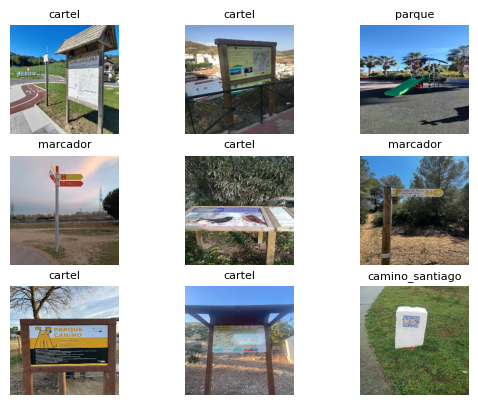

In [7]:
sample_ds_dfd(x_train)

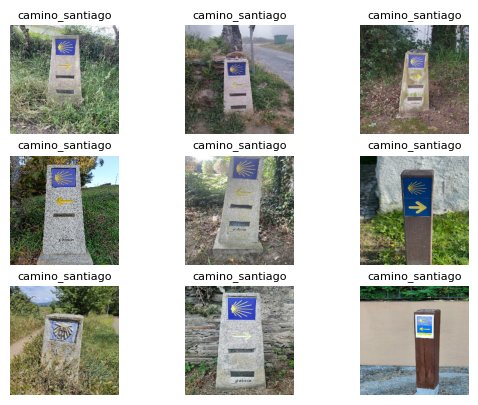

In [8]:
sample_ds_dfd(x_test)

Se crea un modelo basado en uno ya entrenado de TensorHub

In [9]:
thub_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
if ENTRENAR: 
    red_mb = tf.keras.Sequential([
        hub.KerasLayer(thub_model, input_shape = (DIM, DIM, 3), trainable = False),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_mb.summary()
    red_mb.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
else: 
    red_mb = tf.keras.models.load_model(RUTA_MODELOS + "red_mb")
    red_mb.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 2268268 (8.65 MB)
Trainable params: 10284 (40.17 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Se realiza el entrenamiento del modelo

In [10]:
if ENTRENAR:
    %load_ext tensorboard
    red_mb.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet")])
    red_mb.save(RUTA_MODELOS + "red_mb")

Se hacen las predicciones sobre el conjunto de test para evaluar el modelo

In [11]:
def predict_dataset(ds, modelo): 
    y_target = []
    y_hat = []
    y_confidence = []
    batches = len(ds)
    for batch, (img_batch, label_batch) in enumerate(ds): 
        if batch == batches: 
            break
        else: 
            for img, label in zip(img_batch, label_batch):
                y_target.append(np.argmax(label))
                y_hat.append(np.argmax(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)[0]))
                y_confidence.append(np.max(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)))
    return np.column_stack((y_target, y_hat, y_confidence)), modelo.predict(ds, verbose = 0)

Y_matrix, Y_score = predict_dataset(x_test, red_mb)

Se muestran las 9 primeras predicciones como ejemplo

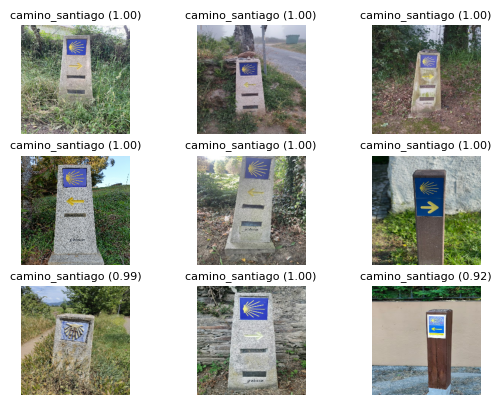

In [12]:
def sample_predict_ds_fd(ds, Y_matrix): 
    for img_batch, _ in ds.take(1):
        for i, img in enumerate(img_batch): 
            prediccion = int(Y_matrix[i, 1])
            plt.subplot(3, 3, i + 1)
            plt.title(f"{ds.class_names[prediccion]} ({Y_matrix[i, 2]:.2f})", fontsize = 8)
            plt.imshow(img.numpy())
            plt.axis("off")
            if i == 8: 
                break

sample_predict_ds_fd(x_test, Y_matrix)

### Métricas
¿Realmente ha sido un buen modelo? 
#### Matriz de confusión

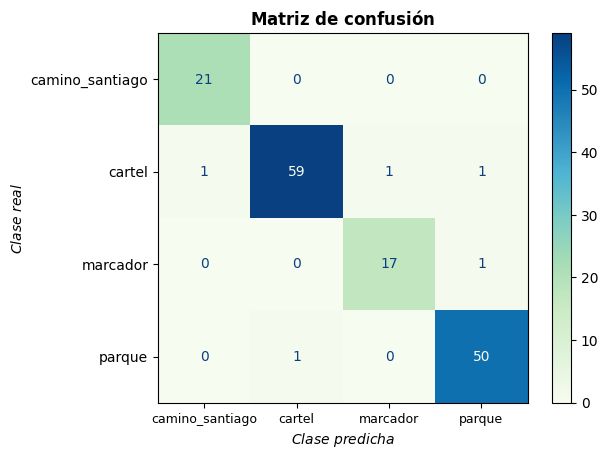

In [13]:
def matriz_confusion(ds, Y_matrix, save = None): 
    cm = sk.metrics.confusion_matrix(Y_matrix[:, 0], Y_matrix[:, 1])
    diagrama = sk.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ds.class_names).plot(
        include_values = True, 
        cmap = plt.cm.GnBu, 
        ax = plt.gca()
    )
    diagrama.ax_.set_title(r"$\mathbf{Matriz\ de\ confusión}$")
    diagrama.ax_.set_xlabel(r"$\mathit{Clase\ predicha}$")
    diagrama.ax_.set_ylabel(r"$\mathit{Clase\ real}$")
    diagrama.ax_.tick_params(axis = "x", labelsize = 9)
    if save: 
        plt.savefig(f"{save}.pdf", format = "pdf", bbox_inches = "tight")

matriz_confusion(x_test, Y_matrix, save = RUTA_IMG + "mc_mb")

#### Resumen de métricas

* **Precisión**: de todos los elementos clasificados como $C_i$, ¿cuántos realmente pertenecen a dicha clase?
$$
\mathcal{P} = P(C_i | \hat{C}_i) = \frac{P(C_i \cap \hat{C}_i)}{P(\hat{C}_i)}
$$

* **Sensibilidad**: de todos los elementos de la clase $C_i$, ¿cuántos se han clasificado como tal?
$$
\mathcal{R} = P(\hat{C}_i | C_i) = \frac{P(\hat{C}_i \cap C_i)}{P(C_i)}
$$

* $F_1-$ Score: en general, ¿cómo de bueno es el clasificador?
$$
F_1 = \frac{2}{\mathcal{P}^{-1} + \mathcal{R}^{-1}}
$$

In [14]:
def metricas_matriz_confusion(ds, Y_matrix, dict = False):
    return sk.metrics.classification_report(
                                 Y_matrix[:, 0], Y_matrix[:, 1], 
                                 target_names = ds.class_names, 
                                 digits = 3, 
                                 output_dict = dict
                                )

mmc = metricas_matriz_confusion(x_test, Y_matrix)
print(mmc)
with open(RUTA_IMG + "mmc_mb.txt", "w") as f: 
    f.write(mmc)

                 precision    recall  f1-score   support

camino_santiago      0.955     1.000     0.977        21
         cartel      0.983     0.952     0.967        62
       marcador      0.944     0.944     0.944        18
         parque      0.962     0.980     0.971        51

       accuracy                          0.967       152
      macro avg      0.961     0.969     0.965       152
   weighted avg      0.967     0.967     0.967       152



* Coeficiente $\kappa$ de Cohen: otra manera de medir la calidad del clasificador. 

In [15]:
def kappa_cohen(Y_matrix): 
    return sk.metrics.cohen_kappa_score(Y_matrix[:, 0], Y_matrix[:, 1]).round(3)

kappa_cohen(Y_matrix)

0.952

* Curvas ROC y área AUC: en el caso de varias clases existen diferentes formas de interpretar y calcular las curvas ROC y su AUC. Predominan los algoritmos OvO y OvR. OvO consiste en realizar una media ponderada de los $2\binom{c}{2}$ posibles AUC. Es decir, para cada posible pareja de clases se considera como un caso de clasificación binaria donde se representa $P(\hat{C}_i | C_i)$ frente a $P(\hat{C}_i | C_j)$, y $P(\hat{C}_j | C_j)$ frente a $P(\hat{C}_j | C_i)$ y cada AUC obtenido se pondera respectivamente mediante $P(C_i)$ y $P(C_j)$. De esta manera el mal AUC de una pareja es proporcional al número de observaciones de las clases que compara, siendo útil para casos de clases desbalanceadas como este. 
$$
\mathcal{A}_{\text{ovo}} = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k \neq j}^c P(C_j)\mathcal{A}(C_j | C_k) = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k > j}^c P(C_j \cup C_k)(\mathcal{A}(C_j | C_k) + \mathcal{A}(C_k | C_j))
$$

In [16]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovr", average = "weighted")

0.9983573102007766

In [17]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovo", average = "weighted")

0.9985925208604476

Para hacerlo un poco más ilustrativo, se puede programar una función propia de AUC OvR donde se vean las gráficas correspondientes a las $c$ clases. 

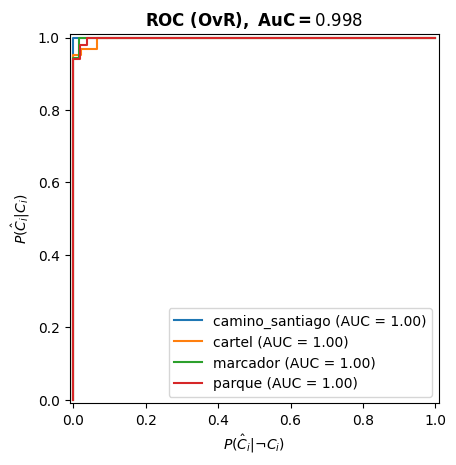

0.9983573102007766

In [18]:
def roc_auc_ovr(Y_matrix, Y_score, clases, save = None): 
    Y_ms = np.column_stack((Y_matrix[:, :-1], Y_score))
    _, ax = plt.subplots()
    auc_ovr = 0

    for i in range(Y_score.shape[1]): 
        Y_ms_temp = Y_ms.copy()
        Y_ms_temp[:, 0] = np.where(Y_ms_temp[:, 0] != i, -1, 1)
        fpr, tpr, _ = sk.metrics.roc_curve(y_true = Y_ms_temp[:, 0], y_score = Y_ms_temp[:, i + 2], pos_label = 1)
        auc = sk.metrics.auc(fpr, tpr)
        prop = np.mean(Y_ms_temp[:, 0] == 1)
        auc_ovr += auc * prop
        sk.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=f"{clases[i]}").plot(ax = ax)
    
    ax.set_title(r"$\mathbf{ROC\ (OvR),\ AuC = }$" + str(auc_ovr.round(3)))
    ax.set_xlabel(r"$P(\hat{C}_i | \neg C_i)$")
    ax.set_ylabel(r"$P(\hat{C}_i | C_i)$")
    if save: 
        plt.savefig(f"{save}.pdf", format = "pdf", bbox_inches = "tight")
    plt.show()
    return auc_ovr

roc_auc_ovr(Y_matrix, Y_score, x_val.class_names, save = RUTA_IMG + "auc_mb")

Se pueden asociar todas en una única función por comodidad: 

In [19]:
def metricas_prediccion(ds, Y_matrix, Y_score, save = None): 
    matriz_confusion(ds, Y_matrix, save = f"{RUTA_IMG}mc_{save}" if save else None)
    mmc = metricas_matriz_confusion(ds, Y_matrix)
    print(mmc)
    print(f"Kappa de Cohen: {kappa_cohen(Y_matrix)}")
    print(f"AUC (OvO): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovo', average = 'weighted').round(3)}")
    print(f"AUC (OvR): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovr', average = 'weighted').round(3)}")
    roc_auc_ovr(Y_matrix, Y_score, ds.class_names, save = f"{RUTA_IMG}auc_{save}" if save else None)
    if save: 
        with open(f"{RUTA_IMG}mmc_{save}.txt", "w") as f: 
            f.write(mmc)

Ahora se va a hacer una rápida comparación creando una red convolucional desde cero, y entrenándola también desde cero, para poder destacar el poder del transfer learning. 

In [20]:
if ENTRENAR: 
    red_conv = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_conv.summary()
    red_conv.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
else: 
    red_conv = tf.keras.models.load_model(RUTA_MODELOS + "red_conv.keras")
    red_conv.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)     

Entrenamos el modelo

In [21]:
if ENTRENAR: 
    red_conv.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_cnn")])
    red_conv.save(RUTA_MODELOS + "red_conv.keras")

Aplicamos las mismas métricas de evaluación

                 precision    recall  f1-score   support

camino_santiago      0.783     0.857     0.818        21
         cartel      0.776     0.952     0.855        62
       marcador      0.875     0.389     0.538        18
         parque      0.844     0.745     0.792        51

       accuracy                          0.803       152
      macro avg      0.820     0.736     0.751       152
   weighted avg      0.812     0.803     0.791       152

Kappa de Cohen: 0.705
AUC (OvO): 0.906
AUC (OvR): 0.912


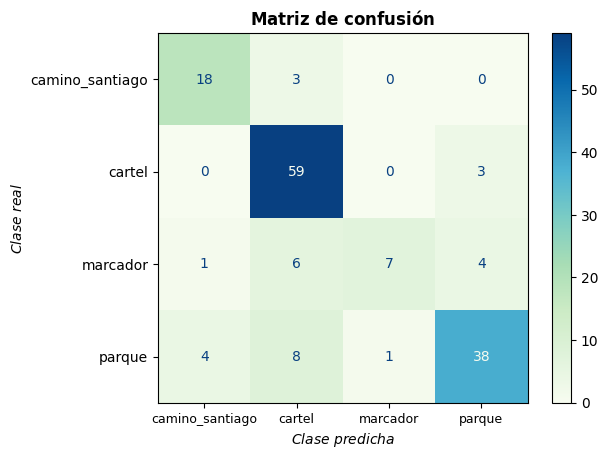

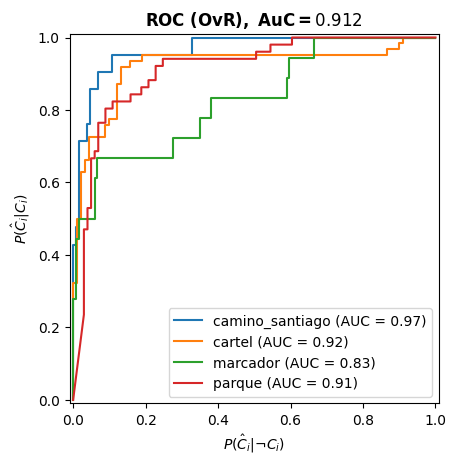

In [22]:
Y_matrix_conv, Y_score_conv = predict_dataset(x_test, red_conv)
metricas_prediccion(x_test, Y_matrix_conv, Y_score_conv, save = "conv")

Se nota que es peor, además de un claro sobreajuste en el entrenamiento, y que este es más costoso. Aún así para haberlo entrenado de cero y teniendo tan pocos datos, no está tan mal. Cuidado también con mirar sólo los AUC, algunos pueden tenerlo alto aún habiendo clasificado mal. Hay que mirarlos junto con el resto de métricas. Se nota como con transfer learning, las capas convolucionales saben qué características obtener de la imagen, aquí no terminan de ser capaces y tienden a memorizar el dataset. 

Se va a proceder a la técnica del aumento de datos. Se va a crear el mismo dataset pero haciendo modificaciones sobre las imágenes, de manera que se reentrene la red aprendiendo a extraer las mismas características de imágenes similares. 

In [23]:
generador_original = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

generador_modificado = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 10,
    zoom_range = [0.25, 1.25],
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

x_train_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

x_train_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

Found 485 images belonging to 4 classes.


Found 118 images belonging to 4 classes.
Found 485 images belonging to 4 classes.
Found 118 images belonging to 4 classes.


Se muestran las imágenes modificadas

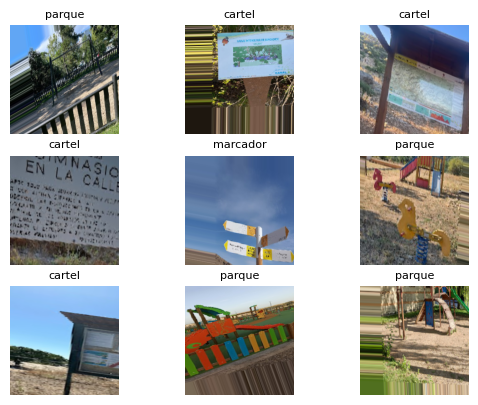

In [24]:
sample_ds_ffd(x_train_au)

Ahora se toman los modelos idénticos a los anteriores y se entrena sobre ellos con el dataset modificado para comprobar si esta técnica aporta diferencias al entrenamiento

In [25]:
if ENTRENAR: 
    red_mb_2 = tf.keras.Sequential([
        hub.KerasLayer(thub_model, input_shape = (DIM, DIM, 3), trainable = False),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_mb_2.summary()
    red_mb_2.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    red_conv_2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_conv_2.summary()
    red_conv_2.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
else: 
    red_mb_2 = tf.keras.models.load_model(RUTA_MODELOS + "red_mb_2")
    red_conv_2 = tf.keras.models.load_model(RUTA_MODELOS + "red_conv_2.keras")

In [26]:
if ENTRENAR: 
    %load_ext tensorboard
    red_mb_2.fit(x_train_au, epochs = 15, validation_data = x_val_au, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_augmented")])
    red_mb_2.fit(x_train_2, epochs = 15, validation_data = x_val_2, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_augmented")])
    red_conv_2.fit(x_train_au, epochs = 15, validation_data = x_val_au, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_conv_augmented")])
    red_conv_2.fit(x_train_2, epochs = 15, validation_data = x_val_2, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_conv_augmented")])
    red_mb_2.save(RUTA_MODELOS + "red_mb_2")
    red_conv_2.save(RUTA_MODELOS + "red_conv_2.keras")

En caso de que se tengan pocos datos y malos resultados es una técnica que ayuda a mejorar. Cuidado porque también puede dar lugar a overfitting. A continuación se evalúa con las métricas empleadas previamente. 

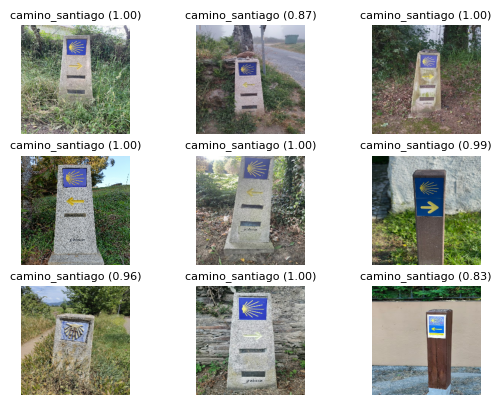

In [27]:
Y_matrix_mbau, Y_score_mbau = predict_dataset(x_test, red_mb_2)
sample_predict_ds_fd(x_test, Y_matrix_mbau)

                 precision    recall  f1-score   support

camino_santiago      1.000     1.000     1.000        21
         cartel      0.984     1.000     0.992        62
       marcador      1.000     0.944     0.971        18
         parque      0.980     0.980     0.980        51

       accuracy                          0.987       152
      macro avg      0.991     0.981     0.986       152
   weighted avg      0.987     0.987     0.987       152

Kappa de Cohen: 0.981
AUC (OvO): 0.999
AUC (OvR): 0.999


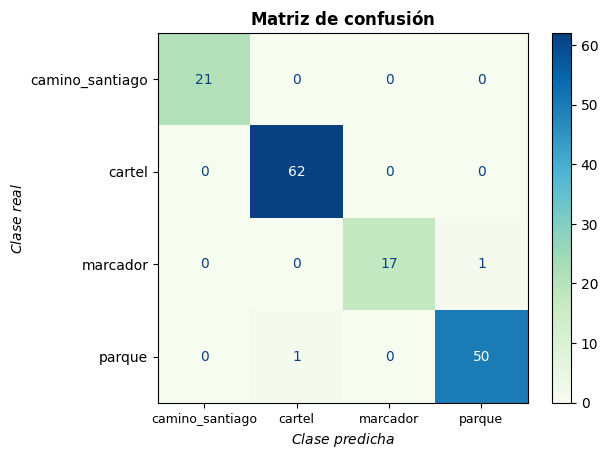

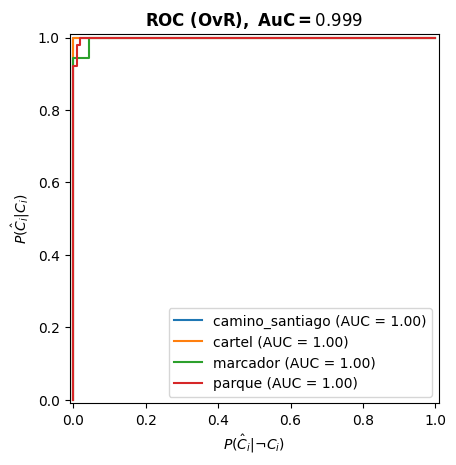

In [28]:
metricas_prediccion(x_test, Y_matrix_mbau, Y_score_mbau, save = "mbau")

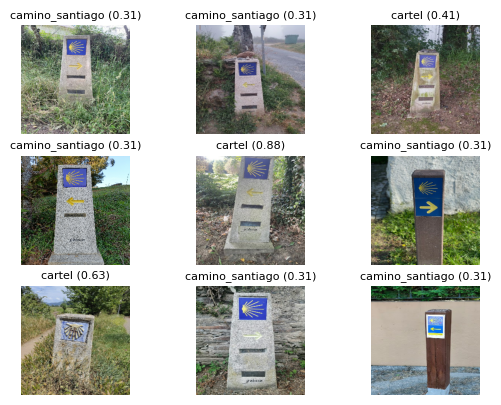

In [29]:
Y_matrix_convau, Y_score_convau = predict_dataset(x_test, red_conv_2)
sample_predict_ds_fd(x_test, Y_matrix_convau)

c:\Users\pgarc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pgarc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pgarc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                 precision    recall  f1-score   support

camino_santiago      0.941     0.762     0.842        21
         cartel      0.656     0.952     0.776        62
       marcador      0.000     0.000     0.000        18
         parque      0.844     0.745     0.792        51

       accuracy                          0.743       152
      macro avg      0.610     0.615     0.603       152
   weighted avg      0.681     0.743     0.699       152

Kappa de Cohen: 0.601
AUC (OvO): 0.863
AUC (OvR): 0.889


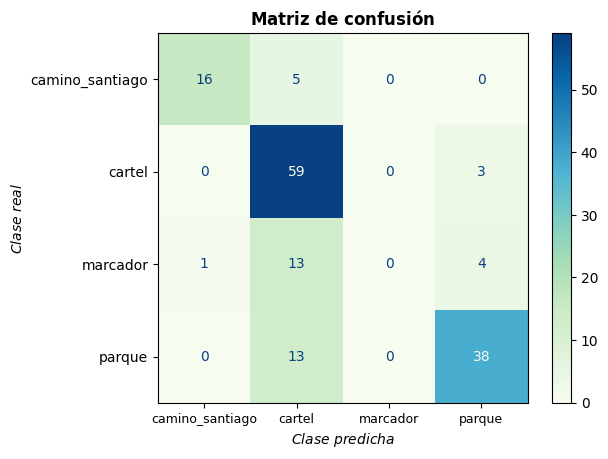

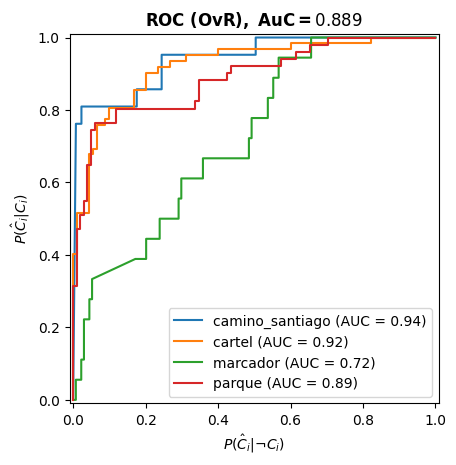

In [30]:
metricas_prediccion(x_test, Y_matrix_convau, Y_score_convau, save = "convau")

Hasta ahora, en los conjuntos de entrenamiento, validación, y test había fotos de los elementos seleccionados de diferentes partes de España. Algunos elementos como los marcadores del Camino de Santiago, varían su aspecto dependiendo de la zona de España. Lo que se va a hacer para probar la eficacia del modelo, es separar de una manera diferente las imágenes. En el conjunto de entrenamiento y validación aparecerán imágenes de diferentes partes de España, mientras en el conjunto de test, sólo habrán fotos de la ciudad de Guadalajara. 

In [31]:
RUTA_TRAIN_GU = RUTA_TRAIN.replace("tfg_dataset", "tfg_dataset_gu")
RUTA_TEST_GU = RUTA_TEST.replace("tfg_dataset", "tfg_dataset_gu")

x_train_gu, x_val_gu = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TRAIN_GU,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

x_test_gu = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TEST_GU,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

class_names = x_train_gu.class_names
x_train_gu = x_train_gu.map(lambda x, y: (norm(x), y))
x_val_gu = x_val_gu.map(lambda x, y: (norm(x), y))
x_test_gu = x_test_gu.map(lambda x, y: (norm(x), y))
x_train_gu.class_names = class_names
x_val_gu.class_names = class_names
x_test_gu.class_names = class_names

Found 586 files belonging to 4 classes.
Using 469 files for training.
Using 117 files for validation.
Found 102 files belonging to 4 classes.


Se utilizará la arquitectura que mejores resultados ha dado (cnn con transfer learning), y se reentrenará, pues algunas de estas imágenes se encontraban en los conjuntos de entrenamiento y validación anteriores, y evaluar sin entrenar de nuevo desde cero, sería "hacer trampa". 

In [32]:
if ENTRENAR: 
    red_gu = tf.keras.Sequential([
        hub.KerasLayer(thub_model, input_shape = (DIM, DIM, 3), trainable = False),
        tf.keras.layers.Dense(2 * len(x_train_gu.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train_gu.class_names), activation = "softmax")
    ])
    red_gu.summary()
    red_gu.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    red_gu.fit(x_train_gu, epochs = 25, validation_data = x_val_gu, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_guada")])
    red_mb.save(RUTA_MODELOS + "red_gu")
else: 
    red_gu = tf.keras.models.load_model(RUTA_MODELOS + "red_gu")
    red_gu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 2268268 (8.65 MB)
Trainable params: 10284 (40.17 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Ahora se evalúa el modelo con los datos explicados previamente

                 precision    recall  f1-score   support

camino_santiago      1.000     0.833     0.909         6
         cartel      0.949     0.974     0.961        38
       marcador      0.667     0.400     0.500         5
         parque      0.945     0.981     0.963        53

       accuracy                          0.941       102
      macro avg      0.890     0.797     0.833       102
   weighted avg      0.936     0.941     0.936       102

Kappa de Cohen: 0.897
AUC (OvO): 0.992
AUC (OvR): 0.997


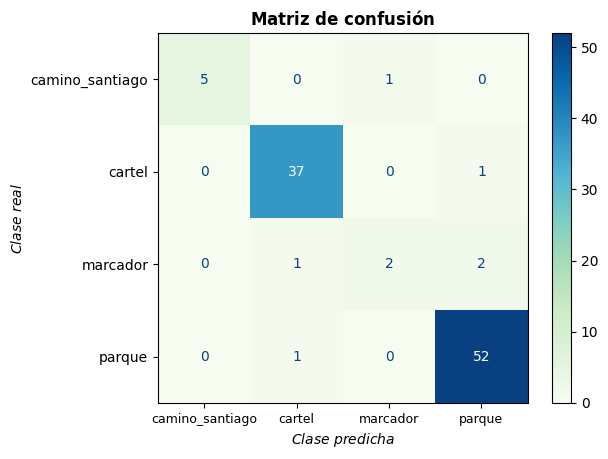

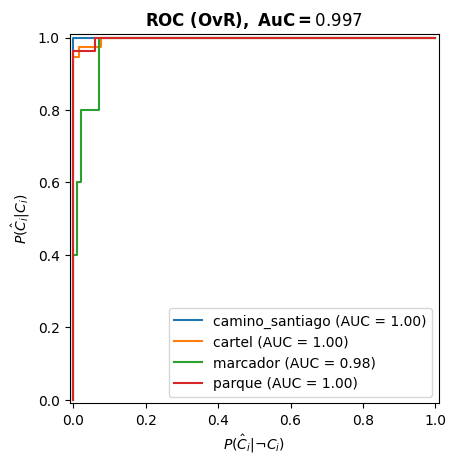

In [33]:
Y_matrix_gu, Y_score_gu = predict_dataset(x_test_gu, red_gu)
metricas_prediccion(x_test_gu, Y_matrix_gu, Y_score_gu, save = "gu")

Los resultados obtenidos han sido adecuados, sobre todo destacando el caso de los hitos del Camino de Santiago de Guadalajara, cuya forma no se parece a los que ha visto durante el entrenamiento, que pertenecen a Galicia. Se puede observar de manera clara la generalización del modelo en la siguiente figura. 

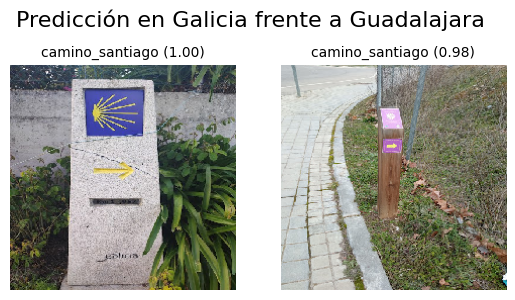

In [34]:
cs_gu = np.array(tf.keras.utils.load_img(RUTA_TEST_GU + "/camino_santiago/0.jpg", target_size = (DIM, DIM))) / 255.
cs_ga = np.array(tf.keras.utils.load_img(RUTA_TRAIN_GU + "/camino_santiago/0.jpeg", target_size = (DIM, DIM))) / 255.

pred_gu = red_gu.predict(np.expand_dims(cs_gu, axis = 0), verbose = 0)
pred_ga = red_gu.predict(np.expand_dims(cs_ga, axis = 0), verbose = 0)

plt.suptitle("Predicción en Galicia frente a Guadalajara", fontsize = 16)
plt.subplots_adjust(top = 1.15)
plt.subplot(1, 2, 1)
plt.title(f"{x_test_gu.class_names[np.argmax(pred_ga)]} ({np.max(pred_ga):.2f})", fontsize = 10)
plt.imshow(cs_ga)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title(f"{x_test_gu.class_names[np.argmax(pred_gu)]} ({np.max(pred_gu):.2f})", fontsize = 10)
plt.imshow(cs_gu)
plt.axis("off")
plt.savefig(RUTA_IMG + "gu_vs_ga.pdf", format = "pdf", bbox_inches = "tight")

En general, los resultados obtenidos han sido buenos. En la mayoría de clases, la generalización ha sido buena, aunque no se puede establecer una conclusión muy firme, pues se tienen pocos datos de prueba. 